## Bermuda option pricing using LSMC

在金融产品定价上，蒙特卡洛主要根据大数定律以及中央极限定理为理论基础将期望表达式转换成算术平均表达式，然后模拟每条路径上的产品支付函数，将其累加再求平均值

In [35]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import polyfit, polyval
from numpy.polynomial.laguerre import lagfit, lagval
from scipy.stats import norm
  

In [7]:
np.random.seed(1031)
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False


In [8]:
import cufflinks as cf 
cf.go_offline()

## 欧式期权、美式期权和百慕大期权蒙特卡洛定价

\begin{equation}
S(T) = S(0) \cdot \exp ((r-q-\frac{1}{2} \sigma ^2 ) + \sigma \sqrt T \cdot z) 
\end{equation}

- 其中 $z$ ~ N(0,1),标准正态分布随机变量

In [47]:
(S0,r,q,T,sigma) = (1,0.02,0,1,0.2)
(Nsim, Nt) = (20,2) #为了简便只有两个时间点，0，1

t = np.linspace(0,T,Nt)
dt = np.diff(t)

z = np.random.randn(Nsim, Nt-1)
A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

lnS0 = np.tile(np.log(S0),(Nsim,1))
lnS = lnS0 + np.cumsum(A,axis=1)
lnS = np.hstack((lnS0,lnS))
S = np.exp(lnS)

In [48]:
label = [x + ' ' + str(y) for x,y in zip(['path']*Nsim, np.arange(1,Nsim+1))]
df = pd.DataFrame(S.T, index=t,columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10,path 11,path 12,path 13,path 14,path 15,path 16,path 17,path 18,path 19,path 20
0.0,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000
1.0,1.167724,1.209408,0.906539,0.777923,1.0362,0.771582,0.881193,0.918087,0.778365,1.131053,1.007664,1.209815,1.076163,0.739582,1.199333,0.996561,0.89588,1.109042,1.40906,0.998132


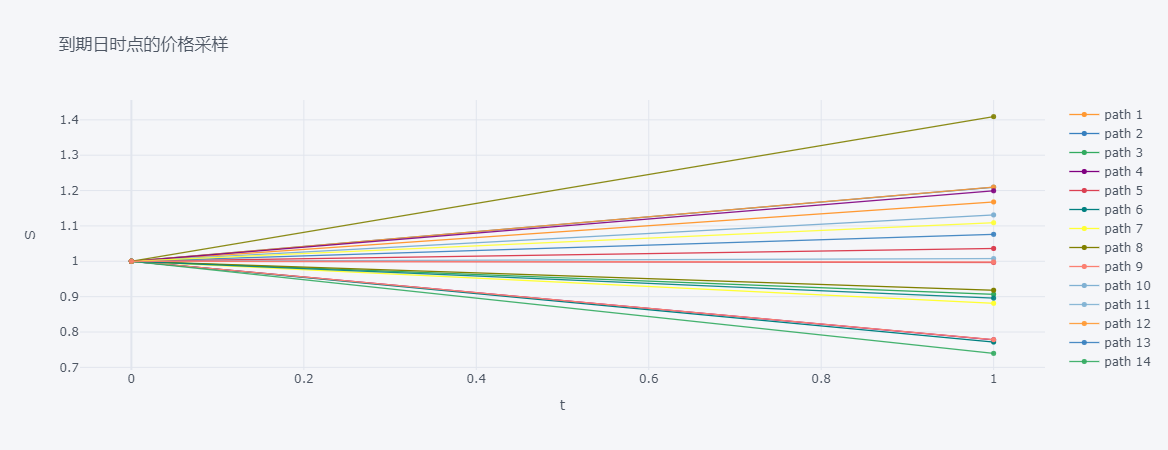

In [56]:
df.iplot(xTitle = 't', yTitle ='S',mode = 'lines+markers', size=5,title = '到期日时点的价格采样')

### 使用蒙特卡洛模拟出到期时点的价格是为了求所有的模拟的均值，比较样本均值和真实值的（BS模型下的解析解），确保采样的质量。

In [57]:
# BS真实值
S0*np.exp(r*T)

1.0202013400267558

In [58]:
def underlying (S0,r,q,T,sigma,Nsim,Nt):
    """
    calculate the undl assets price
    """
    t = np.linspace(0,T,Nt)
    dt = np.diff(t)

    z = np.random.randn(Nsim, Nt-1)
    A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A,axis=1)
    lnS = np.hstack((lnS0,lnS))
    S = np.exp(lnS)
    return S

In [59]:
Nsim = [1,10,100,1000,10000,100000]
Ntrial = 100
results = np.zeros((Ntrial,len(Nsim)))

for i in np.arange(Ntrial):
    for j,N in enumerate(Nsim):
        S = underlying(S0,r,q,T,sigma,N,Nt)
        results[i,j] = np.mean(S[:,-1])


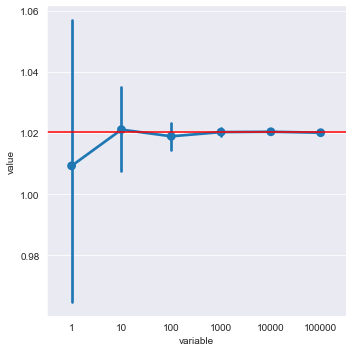

In [60]:
df = pd.DataFrame( results, columns=Nsim)
sns.set_style(style="darkgrid")
g = sns.catplot(x="variable",y ="value", kind = 'point',data=df.melt())

true_mean = S0 * np.exp(r*T)
plt.axhline(y=true_mean,color ='red')

## 定价一个欧式看跌期权

In [76]:
(S0,K,r,q,T,sigma,omega) = (1,1.1,0.02,0,1,0.2,-1)
(Nsim, Nt) = (100000,2)

In [77]:
#首先采样到期日节点的标的资产价格 S（T）
Smat = underlying(S0,r,q,T,sigma,Nsim,Nt)
S = Smat[:,-1]

In [78]:
S

array([1.12115808, 1.02348555, 0.83513941, ..., 1.1801886 , 1.00245005,
       0.78723187])

In [79]:
#在到期日将S(T)代入到期权的PAYOFF支付函数中 max(K-S(T),0) 计算均值得到到期期权价格
V_MC = np.exp(-r*T) * np.mean(np.maximum(omega*(S-K),0))
V_MC

0.1281365039127368

In [80]:
# 与解析解BS进行比较，两个值相近
def BlackScholes(S0=100,K=100,r=0.01,q=0.01,T=1,sigma = 0.2,omega=1):
    discount = np.exp(-r*T)
    forward = S0 * np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma * np.sqrt(T)

    d1 = moneyness / vol_sqrt_T + 0.5 * vol_sqrt_T
    d2 = d1 - vol_sqrt_T

    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

In [81]:
V_BS = BlackScholes(S0,K,r,q,T,sigma,omega)
V_BS

0.12765721020973578

## 使用对立变量来缩减误差

In [82]:
def underlying_AV (S0,r,q,T,sigma,Nsim,Nt,antithetic=False):

    t=np.linspace(0,T,Nt)
    dt = np.diff(t)

    if antithetic:
        z1 = np.random.randn(int(Nsim/2),Nt-1) #先生成一半的数
        z = np.vstack([z1,-z1]) #直接求相反数生成剩下的一半

    else:
        z= np.random.randn(Nsim,Nt -1 )
    
    A = (r-q-0.5*(sigma)**2)*dt + sigma * (z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A,axis=1)
    lnS = np.hstack((lnS0,lnS))
    S = np.exp(lnS)
    return S

In [83]:
V_MC = np.exp(-r*T) * np.mean(np.maximum(omega*(S-K),0))
V_MC

0.1281365039127368

In [84]:
Smat_av = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)
S_av = Smat_av[:,-1]
V_AV = np.exp(-r*T) * np.mean(np.maximum(omega*(S_av-K),0))
V_AV

0.127504018761304

## 美式期权定价
- 路径模拟


\begin{equation}
S(t_{n+1}) = S(t_n) \cdot \exp ((r-q-\frac{1}{2} \sigma ^2 ) \cdot \delta t + \sigma \sqrt {\delta t} \cdot z) 
\end{equation}

\begin{equation}
ln S(t_{n+1}) = ln S(t_n) + (r-q-\frac{1}{2} \sigma ^2 ) \cdot \delta t + \sigma \sqrt {\delta t} \cdot z
\end{equation}

- 先模拟 $lnS(T)$ 再用 $exp (lnS(T))$ 返回 $S(T)$ 

In [89]:
(S0,r,q,T,sigma) = (1,0.02,0,1,0.2)
(Nsim, Nt) = (30,100)
S = underlying(S0,r,q,T,sigma,Nsim,Nt)
t = np.linspace(0,T,Nt)
label = [ x + ' ' + str(y) for x,y in zip (['path'] * Nsim, np.arange(1,Nsim+1))]
df = pd.DataFrame(S.T, index=t,columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10,...,path 21,path 22,path 23,path 24,path 25,path 26,path 27,path 28,path 29,path 30
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.010101,1.005065,1.016053,1.037341,1.040520,0.988251,0.976515,1.002562,0.978993,0.992926,1.000279,...,1.013003,0.998729,1.004270,1.025901,1.021748,1.019598,0.996347,1.010214,1.006459,1.010239
0.020202,1.002637,0.998913,1.076339,1.065950,0.993791,0.975938,1.009887,0.999051,1.002701,1.002288,...,0.988115,1.016472,1.006147,1.053049,1.011577,1.028687,1.015564,1.021599,1.030750,0.968581
0.030303,1.013107,1.010461,1.036797,1.076048,0.951915,0.983695,1.003934,1.024637,0.964979,0.999586,...,1.012682,1.036433,0.985187,1.046191,1.044818,1.016436,1.003102,1.024893,1.062224,0.999822
0.040404,1.016451,0.989231,1.033054,1.079766,0.980977,0.996368,1.044480,1.032662,0.969168,1.011321,...,0.986919,1.042603,0.997309,1.047540,1.069712,1.020510,0.970878,1.054703,1.096638,1.005809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.959596,0.722657,0.903937,0.998758,1.381524,1.334455,0.904880,0.983583,0.892085,0.872937,0.899237,...,1.208243,0.816959,1.194007,0.980777,0.761454,1.065462,1.315987,0.969547,1.011735,0.850115
0.969697,0.721064,0.950914,0.988277,1.376520,1.341689,0.894872,0.954739,0.906738,0.888592,0.902932,...,1.198952,0.794175,1.196732,0.989200,0.733375,1.031701,1.323267,0.984718,1.014230,0.854421
0.979798,0.704837,0.941415,0.996195,1.384926,1.321263,0.893373,0.931938,0.901812,0.891556,0.927338,...,1.189578,0.814379,1.140538,1.058111,0.725719,1.052261,1.322017,0.992386,1.005971,0.846252
0.989899,0.688299,0.956534,0.962436,1.374657,1.331252,0.868485,0.929421,0.861588,0.884681,0.915267,...,1.191757,0.805001,1.152834,1.043920,0.696204,1.052137,1.355364,0.986495,0.992311,0.805717


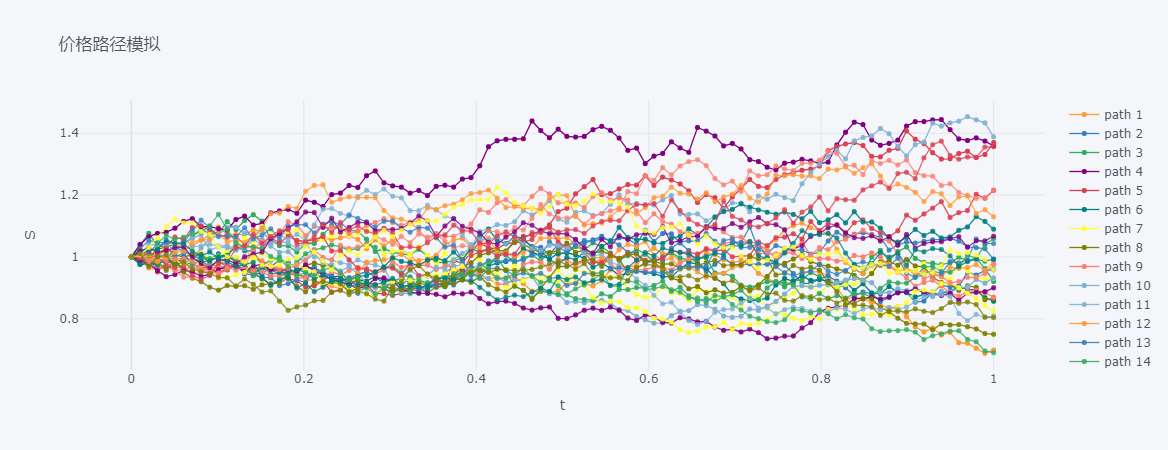

In [90]:
df.iplot( xTitle = 't', yTitle = 'S', mode = 'lines+markers',size=5,title='价格路径模拟')

- LSMC美式期权定价

In [135]:
S = np.array([ [1.00, 1.00, 1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00],
                [1.05065, 1.16053,1.37341,1.040520,0.988251,0.976515,1.2562,0.978993,0.992926,1.0279],
                [1.2637,0.998913,1.076339,1.065950,0.993791,0.975938,1.09887,0.999051,1.2701,1.2288],
                [1.16451,0.989231,1.33054,1.079766,0.980977,0.996368,1.044480,1.2662,0.969168,1.11321] ])
S

array([[1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 1.      , 1.      , 1.      ],
       [1.05065 , 1.16053 , 1.37341 , 1.04052 , 0.988251, 0.976515,
        1.2562  , 0.978993, 0.992926, 1.0279  ],
       [1.2637  , 0.998913, 1.076339, 1.06595 , 0.993791, 0.975938,
        1.09887 , 0.999051, 1.2701  , 1.2288  ],
       [1.16451 , 0.989231, 1.33054 , 1.079766, 0.980977, 0.996368,
        1.04448 , 1.2662  , 0.969168, 1.11321 ]])

In [136]:
(S0,r,K,T,omega) = (1,0.06,1.1,3,-1)
(Nt,Nsim) = (4,S.shape[1])

In [137]:
DF = np.exp(-r*T/(Nt-1))
DF

0.9417645335842487

In [138]:
CF = np.maximum(omega * (S[-1,:]-K),0)
path = np.arange(Nsim)

for i in np.arange(Nt-2,0,-1):
    #discount cashflow from T_{i+1} to T{i}
    CF =  CF * DF

    #find the index of the path where option is in the money
    ITM_bool = omega*(S[i]-K) > 0

    #Slice the uderlying and discounted CF under ITM path
    X = S[i,ITM_bool]
    Y = CF[ITM_bool]

    #Regress Y against X with polynomial function
    coef = polyfit(X,Y,2)

    print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

    #compute the holding value and exercise value
    HV = polyval(coef,X)
    EV = np.maximum(omega*(X-K),0)

    #find the exercise path and update the cashflow
    EP_bool = (EV > HV)
    EP = path[ITM_bool][EP_bool]

    CF[EP] = EV[EP_bool]

V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
V

索引 2 回归函数：E[Y|X] = 16.180x^2 + (-34.141X) + 18.022

索引 1 回归函数：E[Y|X] = 2.923x^2 + (-7.511X) + 4.664



0.10000000000000009

In [139]:
def LSMC(S,K,r,T,N,Nsim,omega,verbose = False):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega * (S[-1,:]-K),0)
    path = np.arange(Nsim)

    for i in np.arange(N-2,0,-1):
        #discount cashflow from T_{i+1} to T{i}
        CF =  CF * DF

        #find the index of the path where option is in the money
        ITM_bool = omega*(S[i]-K) > 0

        #Slice the uderlying and discounted CF under ITM path
        X = S[i,ITM_bool]
        Y = CF[ITM_bool]

        #Regress Y against X with polynomial function
        coef = polyfit(X,Y,2)

        if verbose:
            print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

        #compute the holding value and exercise value
        HV = polyval(coef,X)
        EV = np.maximum(omega*(X-K),0)

        #find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]

    V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
    return V

In [140]:
LSMC(S,K,r,T,Nt,Nsim,omega,verbose=True)

索引 2 回归函数：E[Y|X] = 16.180x^2 + (-34.141X) + 18.022

索引 1 回归函数：E[Y|X] = 2.923x^2 + (-7.511X) + 4.664



0.10000000000000009

## 例子：使用50000个对立变量，因此共100000条路径，每一年分成50个间隔因此51个时点

In [141]:
(S0,K,r,q,sigma,T,omega) = (36,40,0.06,0,0.2,1,-1)
(Nsim,Nt) = (100000,51)
Smat = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)

In [142]:
LSMC(Smat.T,K,r,T,Nt,Nsim,omega,verbose = True)

索引 49 回归函数：E[Y|X] = 0.002x^2 + (-1.110X) + 41.558

索引 48 回归函数：E[Y|X] = 0.003x^2 + (-1.168X) + 42.391

索引 47 回归函数：E[Y|X] = 0.004x^2 + (-1.222X) + 43.184

索引 46 回归函数：E[Y|X] = 0.004x^2 + (-1.256X) + 43.631

索引 45 回归函数：E[Y|X] = 0.005x^2 + (-1.284X) + 44.055

索引 44 回归函数：E[Y|X] = 0.006x^2 + (-1.346X) + 44.949

索引 43 回归函数：E[Y|X] = 0.007x^2 + (-1.385X) + 45.512

索引 42 回归函数：E[Y|X] = 0.007x^2 + (-1.426X) + 46.114

索引 41 回归函数：E[Y|X] = 0.008x^2 + (-1.472X) + 46.800

索引 40 回归函数：E[Y|X] = 0.008x^2 + (-1.494X) + 47.124

索引 39 回归函数：E[Y|X] = 0.009x^2 + (-1.541X) + 47.825

索引 38 回归函数：E[Y|X] = 0.010x^2 + (-1.591X) + 48.578

索引 37 回归函数：E[Y|X] = 0.011x^2 + (-1.626X) + 49.080

索引 36 回归函数：E[Y|X] = 0.012x^2 + (-1.687X) + 50.009

索引 35 回归函数：E[Y|X] = 0.012x^2 + (-1.700X) + 50.216

索引 34 回归函数：E[Y|X] = 0.013x^2 + (-1.759X) + 51.118

索引 33 回归函数：E[Y|X] = 0.013x^2 + (-1.777X) + 51.383

索引 32 回归函数：E[Y|X] = 0.014x^2 + (-1.854X) + 52.570

索引 31 回归函数：E[Y|X] = 0.015x^2 + (-1.916X) + 53.549

索引 30 回归函数：E[Y|X] = 0.016x^2 + 

4.4648961183371325

- 和论文中的4.472非常接近

## 百慕大期权

- 每半年执行权利, 执行日期限 [0.5]
- 每三个月执行权利，期限 [0.25,0.5,0.75]
- 每个月执行权利, 期限 [1/12,2/12,3/12...11/12]

In [143]:
(S0,K,r,q,sigma,T,omega) = (50,60,0.03,0.01,0.4,1,-1)
(Nsim,Nt) = (100000,49)
Smat = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)


In [144]:
V_euro = np.exp(-r*T) * np.mean( np.maximum(omega *(Smat[:,-1]-K),0))
V_euro

13.569692548396981

In [145]:
V_amer = LSMC(Smat.T,K,r,T,Nt,Nsim,omega)
V_amer

13.799563108422833

In [146]:
# Bermudan option

#时间节点
T_vec = np.linspace(0,T,Nt)
T_vec

array([0.        , 0.02083333, 0.04166667, 0.0625    , 0.08333333,
       0.10416667, 0.125     , 0.14583333, 0.16666667, 0.1875    ,
       0.20833333, 0.22916667, 0.25      , 0.27083333, 0.29166667,
       0.3125    , 0.33333333, 0.35416667, 0.375     , 0.39583333,
       0.41666667, 0.4375    , 0.45833333, 0.47916667, 0.5       ,
       0.52083333, 0.54166667, 0.5625    , 0.58333333, 0.60416667,
       0.625     , 0.64583333, 0.66666667, 0.6875    , 0.70833333,
       0.72916667, 0.75      , 0.77083333, 0.79166667, 0.8125    ,
       0.83333333, 0.85416667, 0.875     , 0.89583333, 0.91666667,
       0.9375    , 0.95833333, 0.97916667, 1.        ])

In [147]:
T_ex1 = np.array([0,0.5,T])
idx1 = np.searchsorted(T_vec,T_ex1)
idx1

array([ 0, 24, 48], dtype=int64)

In [148]:
S =Smat[:,idx1].T
S  

array([[50.        , 50.        , 50.        , ..., 50.        ,
        50.        , 50.        ],
       [44.92192559, 32.05928579, 32.46388304, ..., 61.12698769,
        56.0122757 , 37.86095629],
       [49.73153063, 37.19328729, 33.02876837, ..., 54.63157137,
        55.51748274, 44.89451227]])

In [149]:
V_berm1 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm1

13.68841681863041

In [150]:
T_ex2 = np.array([0,0.25,0.5,0.75,T])
idx2 = np.searchsorted(T_vec,T_ex2)
idx2

array([ 0, 12, 24, 36, 48], dtype=int64)

In [151]:
S = Smat[:,idx2].T
V_berm2 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm2

13.765000085410499

In [152]:
T_ex3 = np.arange(13)/12
idx3 = np.searchsorted(T_vec,T_ex3)
idx3

array([ 0,  4,  8, 12, 16, 21, 24, 29, 32, 36, 41, 44, 48], dtype=int64)

In [153]:
S = Smat[:,idx3].T 
V_berm3 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm3

13.783236764673578

In [154]:
d = {'欧式':V_euro,'百慕大(按半年执行)':V_berm1,'百慕大(按季度执行)':V_berm2,'百慕大(按月执行)':V_berm3,'美式':V_amer}
s = pd.Series(d)
s

欧式            13.569693
百慕大(按半年执行)    13.688417
百慕大(按季度执行)    13.765000
百慕大(按月执行)     13.783237
美式            13.799563
dtype: float64

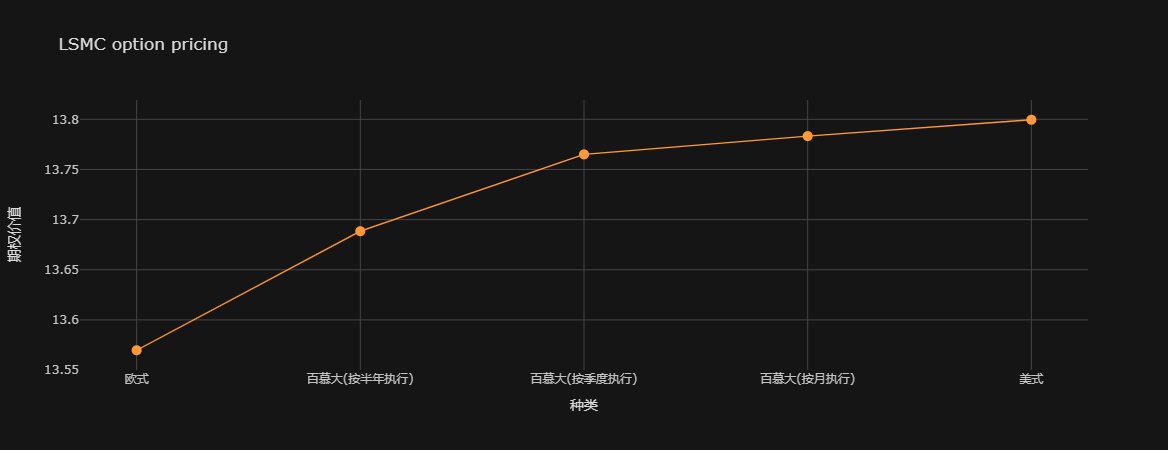

In [155]:
s.iplot(xTitle = '种类',yTitle = '期权价值', mode = 'lines+markers',size = 10,title='LSMC option pricing',theme='solar')

In [156]:
def LSMC_laguerre(S,K,r,T,N,Nsim,omega,verbose = False, fit_type = 'plain'):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega * (S[-1,:]-K),0)
    path = np.arange(Nsim)

    for i in np.arange(N-2,0,-1):
        #discount cashflow from T_{i+1} to T{i}
        CF =  CF * DF

        #find the index of the path where option is in the money
        ITM_bool = omega*(S[i]-K) > 0

        #Slice the uderlying and discounted CF under ITM path
        X = S[i,ITM_bool]
        Y = CF[ITM_bool]

        if fit_type == 'laguerre':
            coef = lagfit(X,Y,3)
            HV = lagval(X,coef)
        else:
            #Regress Y against X with polynomial function
            coef = polyfit(X,Y,2)
            #compute the holding value and exercise value
            HV = polyval(coef,X)

        if verbose:
            print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

        #compute exercise value
        EV = np.maximum(omega*(X-K),0)

        #find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]

    V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
    return V

In [157]:
V_amer_LG = LSMC_laguerre(Smat.T,K,r,T,Nt,Nsim,omega,fit_type = 'laguerre')
V_amer_LG

13.82177974086644

In [160]:
S_LG = Smat[:,idx1].T 
V_berm1_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm1_LG

13.693536166476079

In [161]:
S_LG = Smat[:,idx2].T 
V_berm2_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm2_LG

13.772477384702254

In [162]:
S_LG = Smat[:,idx3].T 
V_berm3_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm3_LG

13.805176302200271

In [166]:
d = {'欧式':V_euro,'百慕大(按半年执行)':V_berm1_LG,'百慕大(按季度执行)':V_berm2_LG,'百慕大(按月执行)':V_berm3_LG,'美式':V_amer_LG}
s = pd.Series(d)
s

欧式            13.569693
百慕大(按半年执行)    13.693536
百慕大(按季度执行)    13.772477
百慕大(按月执行)     13.805176
美式            13.821780
dtype: float64

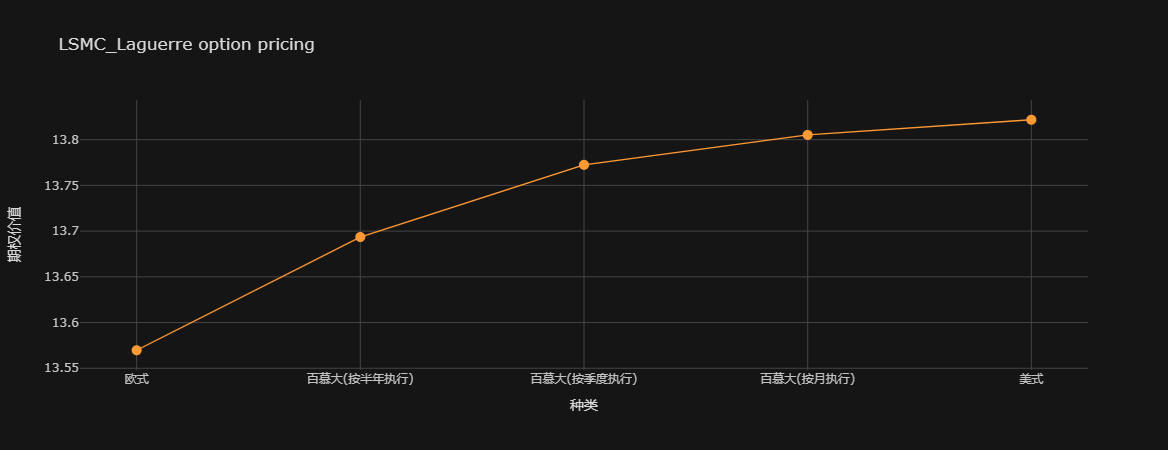

In [167]:
s.iplot(xTitle = '种类',yTitle = '期权价值', mode = 'lines+markers',size = 10,title='LSMC_Laguerre option pricing',theme='solar')